In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [22]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
plt.rc("font", size=14)

In [23]:
appointment_data = pd.read_csv('../data/Medical_No_Shows.csv')


Initial Data Exploration

In [24]:
print(appointment_data.shape)
print(list(appointment_data.columns))
appointment_data.info()

(110527, 14)
['PatientID', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'LocationID', 'MedicaidIND', 'Hypertension', 'Diabetes', 'Alcoholism', 'Disability', 'SMS_received', 'No-show']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PatientID       110527 non-null  object
 1   AppointmentID   110527 non-null  int64 
 2   Gender          110527 non-null  object
 3   ScheduledDay    110527 non-null  object
 4   AppointmentDay  110527 non-null  object
 5   Age             110527 non-null  int64 
 6   LocationID      110527 non-null  int64 
 7   MedicaidIND     110527 non-null  int64 
 8   Hypertension    110527 non-null  int64 
 9   Diabetes        110527 non-null  int64 
 10  Alcoholism      110527 non-null  int64 
 11  Disability      110527 non-null  int64 
 12  SMS_received    110527 non-null  int64 
 13  No

In [25]:
appointment_data.isna().sum()  # no null values in dataset

PatientID         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
LocationID        0
MedicaidIND       0
Hypertension      0
Diabetes          0
Alcoholism        0
Disability        0
SMS_received      0
No-show           0
dtype: int64

In [26]:
print(len(appointment_data['PatientID'].unique()))


62299


PatientID should be an int64 not an object
TODO: take out hashtags and convert into int64


Gender exploration

In [27]:
# Gender exploration
appointment_data['Gender'].value_counts()

F    71840
M    38687
Name: Gender, dtype: int64

In [28]:
appointment_data['Disability'].value_counts()
#  Disability has values outside of what is defined
# TODO: cleanup Disability column

0    108286
1      2042
2       183
3        13
4         3
Name: Disability, dtype: int64

In [29]:
appointment_data[appointment_data['Disability'] == 2] = 1
appointment_data[appointment_data['Disability'] == 3] = 1
appointment_data[appointment_data['Disability'] == 4] = 1
appointment_data['Disability'].value_counts()

0    108286
1      2241
Name: Disability, dtype: int64

since gender is only between M and F, 
one hot encoding could be used

All dtypes are changed after fixing diability class, recasting

In [30]:
appointment_data['No-show'].value_counts()

No     88050
Yes    22278
1        199
Name: No-show, dtype: int64

In [31]:
# Fix the 1's showing up in no-show column to "Yes"
appointment_data['No-show'].replace(1, 'Yes', inplace=True)
appointment_data['No-show'].value_counts()

No     88050
Yes    22477
Name: No-show, dtype: int64

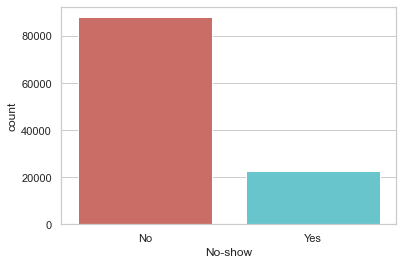

<Figure size 432x288 with 0 Axes>

In [32]:
sns.countplot(x='No-show', data=appointment_data, palette='hls')
plt.show()
plt.savefig('count plot')

There is significantly more patients that keep their patients than not 

In [33]:
count_no_show = len(appointment_data[appointment_data['No-show'] == 'No'])
count_show = len(appointment_data[appointment_data['No-show'] == 'Yes'])
pct_of_no_sub = count_no_show/(count_no_show+count_show)
print("percentage of no-show is", pct_of_no_sub*100)
pct_of_sub = count_show/(count_no_show+count_show)
print("percentage of show", pct_of_sub*100)

percentage of no-show is 79.66379255747465
percentage of show 20.336207442525357


Since the no-show class is imbalanced before putting it into logistic regression (80:20) we need to balance them to 50:50

In [34]:
appointment_data.groupby('No-show').mean()

,AppointmentID,Age,LocationID,MedicaidIND,Hypertension,Diabetes,Alcoholism,Disability,SMS_received
No-show,,,,,,,,,
No,5.681125e+06,37.776650,42.512311,0.093878,0.204066,0.073572,0.030403,0.019035,0.291425
Yes,5.602228e+06,33.984473,41.608400,0.123504,0.175602,0.072118,0.038884,0.025137,0.443742


Obervations from the mean for no-shows vs all features
- average age of patients who do not show up is lower than patients who did show up
- More medicaid patients on average do not show up than non-medicaid patients
- Patients with hypertension on average show up less than patients with hypertension
- Patients receiving SMS on average show up less than patients with no SMS reminder

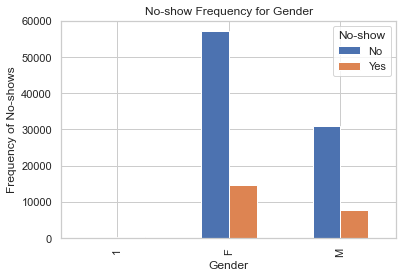

In [35]:
#  No-show Frequency Gender
%matplotlib inline
pd.crosstab(appointment_data['Gender'],
            appointment_data['No-show']).plot(kind='bar')
plt.title('No-show Frequency for Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency of No-shows')
plt.savefig('No_show_frequency_gender')

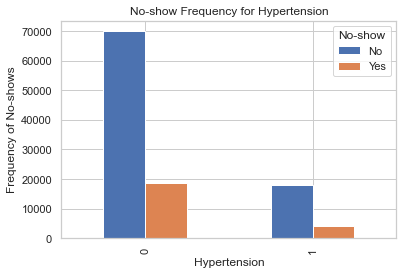

In [36]:
#  No-show Frequency Hypertension
%matplotlib inline
pd.crosstab(appointment_data['Hypertension'],
            appointment_data['No-show']).plot(kind='bar')
plt.title('No-show Frequency for Hypertension')
plt.xlabel('Hypertension')
plt.ylabel('Frequency of No-shows')
plt.savefig('No_show_frequency_hypertension')

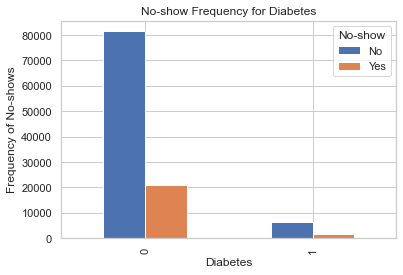

In [37]:
# No-show Frequency Diabetes
%matplotlib inline
pd.crosstab(appointment_data['Diabetes'],
            appointment_data['No-show']).plot(kind='bar')
plt.title('No-show Frequency for Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Frequency of No-shows')
plt.savefig('No_show_frequency_diabetes')


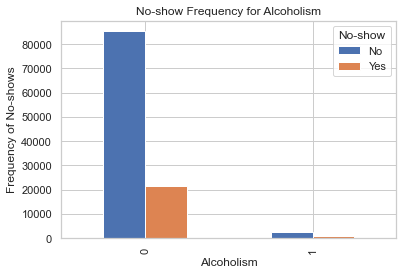

In [38]:
# No-show Frequency Alcoholism
%matplotlib inline
pd.crosstab(appointment_data['Alcoholism'],
            appointment_data['No-show']).plot(kind='bar')
plt.title('No-show Frequency for Alcoholism')
plt.xlabel('Alcoholism')
plt.ylabel('Frequency of No-shows')
plt.savefig('No_show_frequency_alcoholism')

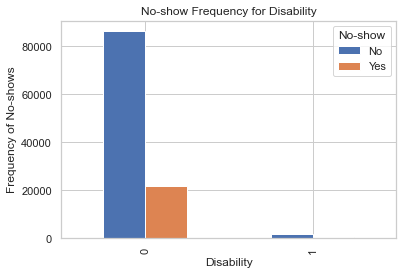

In [39]:
# No-show Frequency Disability
%matplotlib inline
pd.crosstab(appointment_data['Disability'],
            appointment_data['No-show']).plot(kind='bar')
plt.title('No-show Frequency for Disability')
plt.xlabel('Disability')
plt.ylabel('Frequency of No-shows')
plt.savefig('No_show_frequency_disability')

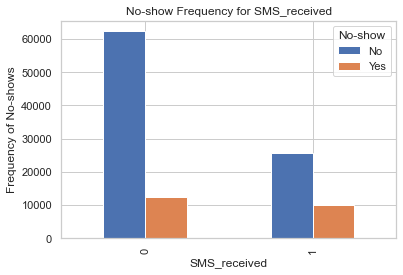

In [40]:
# No-show Frequency SMS_Received
%matplotlib inline
pd.crosstab(appointment_data['SMS_received'],
            appointment_data['No-show']).plot(kind='bar')
plt.title('No-show Frequency for SMS_received')
plt.xlabel('SMS_received')
plt.ylabel('Frequency of No-shows')
plt.savefig('No_show_frequency_SMS')

In [42]:
appointment_data['Gender'].replace(1, 'M', inplace=True)

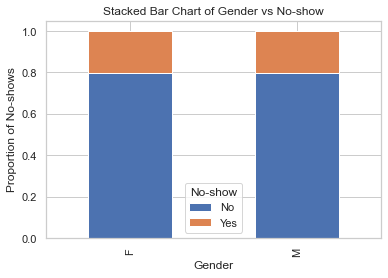

In [43]:
# Stacked bar charts to compare classes with each other without the frequency
table = pd.crosstab(appointment_data['Gender'], appointment_data['No-show'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Gender vs No-show')
plt.xlabel('Gender')
plt.ylabel('Proportion of No-shows')
plt.savefig('gender_vs_noshow_stack')

Despite a higher number of women keeping appointments than men, really at the same rate both genders are no-shows

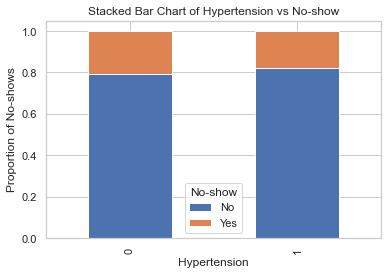

In [44]:
table = pd.crosstab(
    appointment_data['Hypertension'], appointment_data['No-show'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Hypertension vs No-show')
plt.xlabel('Hypertension')
plt.ylabel('Proportion of No-shows')
plt.savefig('hypertension_vs_noshow_stack')

Hypertension seems to be a good predictor with the slight variation between 0 and 1

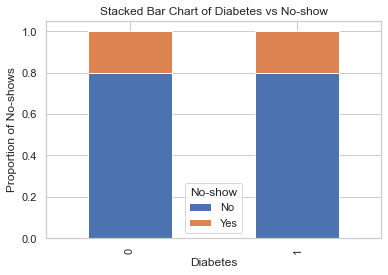

In [45]:
table = pd.crosstab(appointment_data['Diabetes'], appointment_data['No-show'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Diabetes vs No-show')
plt.xlabel('Diabetes')
plt.ylabel('Proportion of No-shows')
plt.savefig('diabetes_vs_noshow_stack')

 diabetes does not seems like a good predictor

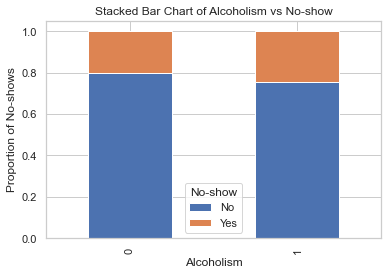

In [46]:
table = pd.crosstab(
    appointment_data['Alcoholism'], appointment_data['No-show'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Alcoholism vs No-show')
plt.xlabel('Alcoholism')
plt.ylabel('Proportion of No-shows')
plt.savefig('alcoholism_vs_noshow_stack')

Alcoholism has a significant variation so it looks like a good predictor

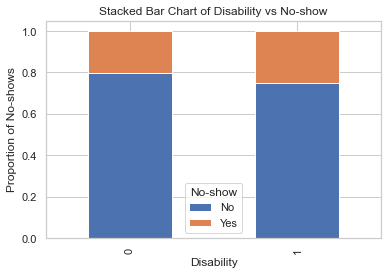

In [47]:
table = pd.crosstab(
    appointment_data['Disability'], appointment_data['No-show'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Disability vs No-show')
plt.xlabel('Disability')
plt.ylabel('Proportion of No-shows')
plt.savefig('disability_vs_noshow_stack')

Disability seems like a good predictor

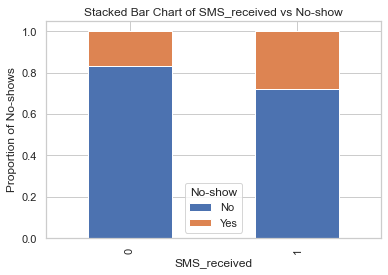

In [48]:
table = pd.crosstab(
    appointment_data['SMS_received'], appointment_data['No-show'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of SMS_received vs No-show')
plt.xlabel('SMS_received')
plt.ylabel('Proportion of No-shows')
plt.savefig('SMS_vs_noshow_stack')

SMS seems like a good predictor

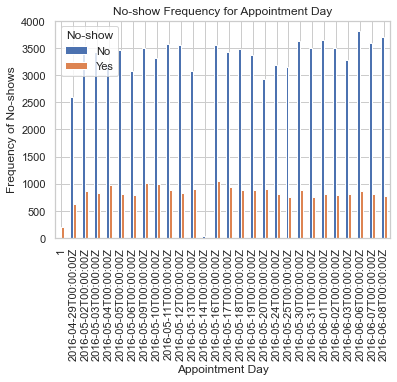

In [49]:
pd.crosstab(appointment_data['AppointmentDay'],
            appointment_data['No-show']).plot(kind='bar')
plt.title('No-show Frequency for Appointment Day')
plt.xlabel('Appointment Day')
plt.ylabel('Frequency of No-shows')
plt.savefig('apptday_fre_noshow_bar')

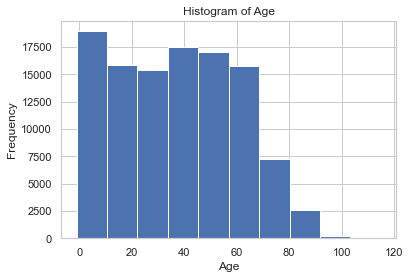

In [50]:
appointment_data['Age'].hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')
# most people are in the range of 0-60

This is a supervised learning problem
since the existing data is already provided ahead of time

Model chosen is logistic regression
since we are trying to predict a binary output and
show the probability of each prediction of said binary output

Assumptions:
Binary logistic regression requires the dependent variable to be binary.
- this is true, either a patient was yes or no for no-show
For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
- Yes can be represented as 1, no as 0
Only the meaningful variables should be included.this will be determined after more analysis
- The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
- this will be explored but from first glance all variables are independent
The independent variables are linearly related to the log odds.

Logistic regression requires quite large sample sizes.
- There are 110527 rows of data, which is sufficiently large

Features to focus on for now for LR model:

-Gender            
-Age               
-LocationID        
-MedicaidIND       
-Hypertension      
-Diabetes          
-Alcoholism        
-Disability        
-SMS_received      

In [51]:
# One Hot Encode Gender
hot_list = pd.get_dummies(appointment_data['Gender'], prefix='hot')
new_data = appointment_data.join(hot_list)
appointment_data = new_data

In [52]:
data_final = appointment_data
data_final.columns.values

array(['PatientID', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'LocationID', 'MedicaidIND',
       'Hypertension', 'Diabetes', 'Alcoholism', 'Disability',
       'SMS_received', 'No-show', 'hot_F', 'hot_M'], dtype=object)

In [53]:
data_final.drop(['PatientID', 'AppointmentID',
                'ScheduledDay', 'AppointmentDay', 'Gender'], axis=1, inplace=True)
data_final['No-show'].replace(['No', 'Yes'], [0, 1], inplace=True)

In [54]:
data_final = data_final.astype('uint8')
data_final.columns.values
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   Age           110527 non-null  uint8
 1   LocationID    110527 non-null  uint8
 2   MedicaidIND   110527 non-null  uint8
 3   Hypertension  110527 non-null  uint8
 4   Diabetes      110527 non-null  uint8
 5   Alcoholism    110527 non-null  uint8
 6   Disability    110527 non-null  uint8
 7   SMS_received  110527 non-null  uint8
 8   No-show       110527 non-null  uint8
 9   hot_F         110527 non-null  uint8
 10  hot_M         110527 non-null  uint8
dtypes: uint8(11)
memory usage: 1.2 MB


Model Setup

In [55]:
X = data_final.loc[:, data_final.columns != 'No-show']
y = data_final.loc[:, data_final.columns == 'No-show']

Oversampling with the SMOTE algorithm to balance the output class

In [56]:
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['No-show'])
# we can Check the numbers of our data
print("length of oversampled data is ", len(os_data_X))
print("Number of not no-shows in oversampled data",
      len(os_data_y[os_data_y['No-show'] == 0]))
print("Number of no-shows", len(os_data_y[os_data_y['No-show'] == 1]))
print("Proportion of not no-shows data in oversampled data is ",
      len(os_data_y[os_data_y['No-show'] == 0])/len(os_data_X))
print("Proportion of no-shows data in oversampled data is ",
      len(os_data_y[os_data_y['No-show'] == 1])/len(os_data_X))

length of oversampled data is  123038
Number of not no-shows in oversampled data 61519
Number of no-shows 61519
Proportion of not no-shows data in oversampled data is  0.5
Proportion of no-shows data in oversampled data is  0.5


Recursive Feature Elimination

In [57]:
data_final_vars = data_final.columns.values.tolist()
y = ['No-show']
X = [i for i in data_final_vars if i not in y]
logreg = LogisticRegression(max_iter=10000)
rfe = RFE(logreg, n_features_to_select=11)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1]


All features pass as true, so all features are significant for the model


In [58]:
# Putting X and y to original data

X = os_data_X
y = os_data_y.values.ravel()

Now look at Feature Importance

Feature: 0, Score: 0.00496
Feature: 1, Score: 0.00767
Feature: 2, Score: 0.15922
Feature: 3, Score: 0.04366
Feature: 4, Score: 0.05805
Feature: 5, Score: 0.09861
Feature: 6, Score: 0.13352
Feature: 7, Score: 0.46480
Feature: 8, Score: 1.69861
Feature: 9, Score: 1.69529


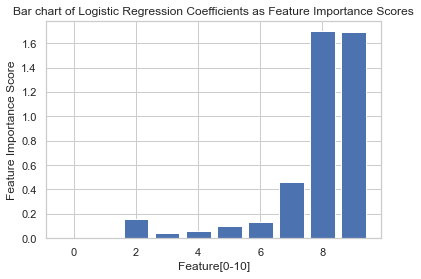

In [60]:
logreg.fit(X, y)
importance = logreg.coef_[0]
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))
plt.bar([x for x in range(len(importance))], importance)
plt.title(
    'Bar chart of Logistic Regression Coefficients as Feature Importance Scores')
plt.xlabel('Feature[0-10]')
plt.ylabel('Feature Importance Score')
plt.show()


Model Implementation

In [61]:
#  Model Implementation
logit_model = sm.Logit(y, X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 8.924746
         Iterations 12


c:\Users\wakef\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


                          Results: Logit
Model:              Logit            Pseudo R-squared: inf         
Dependent Variable: y                AIC:              2196185.6914
Date:               2022-05-09 14:17 BIC:              2196282.8939
No. Observations:   123038           Log-Likelihood:   -1.0981e+06 
Df Model:           9                LL-Null:          0.0000      
Df Residuals:       123028           LLR p-value:      1.0000      
Converged:          1.0000           Scale:            1.0000      
No. Iterations:     12.0000                                        
--------------------------------------------------------------------
                Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
--------------------------------------------------------------------
Age            -0.0015    0.0001   -9.9281  0.0000  -0.0018  -0.0012
LocationID     -0.0022    0.0001  -15.0802  0.0000  -0.0025  -0.0020
MedicaidIND     0.0895    0.0067   13.3792  0.0000   0.0764   0.1026
H

c:\Users\wakef\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:592: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
c:\Users\wakef\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:3511: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


Model Fitting and accuracy

In [62]:
# Model fitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
# logreg = LogisticRegression()
logreg.fit(X_train, y_train)

#  Predicting test results
y_pred = logreg.predict(X_test)

# Printing the Probabilities and showcasing in dataframe
y_probs = logreg.predict_proba(X_test)

# Calculate Accuracy
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(
    logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.64


In [63]:
# Validation with Confusion Matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[15218  3217]
 [10170  8307]]


Classification Report

In [64]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.83      0.69     18435
           1       0.72      0.45      0.55     18477

    accuracy                           0.64     36912
   macro avg       0.66      0.64      0.62     36912
weighted avg       0.66      0.64      0.62     36912



ROC Curve

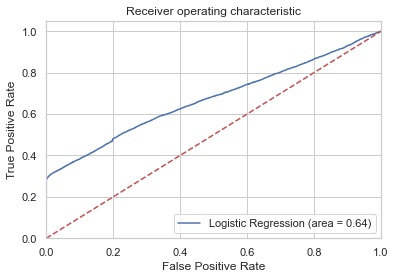

In [65]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
